In [8]:
# Loading libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import gc
import json
import ast
import time
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, KFold, train_test_split, GridSearchCV 
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import eli5
from eli5.sklearn import PermutationImportance
import shap
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape

(250, 302)

In [10]:
# basic EDA

In [36]:
train.head(10)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253
5,5,1.0,-0.641,-0.576,2.493,0.317,0.009,0.428,-1.887,2.412,...,-0.266,1.548,-0.523,0.923,0.021,-0.909,0.629,-2.386,0.265,0.549
6,6,1.0,-0.490,0.557,-0.881,0.831,0.247,2.316,1.268,1.679,...,1.131,0.808,-1.398,0.053,0.667,-1.175,2.330,2.104,0.007,-1.066
7,7,1.0,1.252,-1.370,-0.196,2.246,-0.617,-0.479,-0.629,1.642,...,-1.978,2.801,-1.643,-0.244,-0.864,-0.022,1.598,-0.693,-0.358,-0.084
8,8,1.0,1.410,-1.097,1.170,-0.091,-0.102,-0.835,-1.141,0.355,...,-1.546,-0.190,1.387,1.021,-0.912,0.094,-0.930,1.931,1.190,0.964
9,9,1.0,-1.811,0.566,-0.406,-0.490,-0.985,-0.303,1.068,-0.038,...,-0.705,1.045,-1.281,-1.727,-0.969,-1.367,0.109,1.416,1.472,1.458


In [13]:
# Определенной тематики нет, а значит пользуемся строго формальным описанием, фьючер импортанс и тп. 
# Посмотрим, на распределения, дисперсию, корреляции и далее :)

In [19]:
train.isnull().any()

id        False
target    False
0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
          ...  
270       False
271       False
272       False
273       False
274       False
275       False
276       False
277       False
278       False
279       False
280       False
281       False
282       False
283       False
284       False
285       False
286       False
287       False
288       False
289       False
290       False
291       False
292       False
293       False
294       False
295       False
296       False
297       False
298       False
299       False
Length: 302, dtype: bool

In [20]:
train.isnull().any().any()

False

In [29]:
X_train = train.drop(['id', 'target'], axis = 1)
y_train = train['target']

In [57]:
test.head()

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [58]:
X_test = test.drop(['id'], axis = 1)

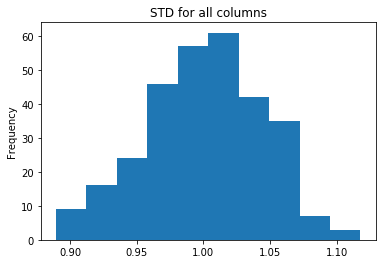

In [40]:
X_train.std().plot('hist')
plt.title('STD for all columns');

Text(0.5, 1.0, 'Means for all columns')

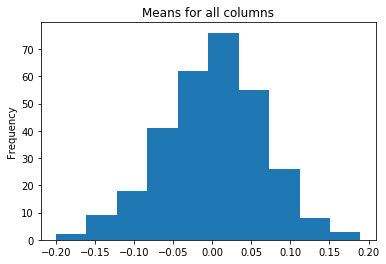

In [39]:
X_train.mean().plot('hist')

plt.title("Means for all columns");

In [41]:
y_train.value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [51]:
corrs = train.corr().abs().unstack().sort_values(ascending=True).reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


In [55]:
# корреляции между признаками маленькие с самой большой в 0.374

In [61]:
n_folds = 10
fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
repeated_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=20, random_state=42)

In [63]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

AttributeError: 'StandardScaler' object has no attribute 'fit_transorm'